# Let's discover the Higgs boson!

The purpose of this exercise is to reproduce one of the plots used in the discovery of Higgs boson by the CMS experiment. We are going to use public data consisting on proton-proton collisions at 8 TeV collected during 2012, part of the LHC Run 1. This exercise is based on http://opendata.cern.ch/record/5500. 


In the following tasks, we will be able to reproduce the plot for the Higgs discovery in the $pp\rightarrow H \rightarrow ZZ \rightarrow 4l $ channel. This implies that a proton-proton collision in the LHC produces a Higgs boson that decays into two Z bosons that immediately decay into 4 leptons (electrons, muons, or taus), which are the particles we will measure in the final state. 

<div class="center">
<img src="imagenes/higgsdecay.png" width="500"/>
<img src="imagenes/SM_table.png" width="350"/>
</div>

**How are we going to work?** 

**ROOT** (https://root.cern/) is the most common data analysis tool in Particle Physics. It can be used un two languages, C++ and Python. We will focus on the Python implementation, **pyROOT**. We won't go in detail over the programming considered in the exercise, and we won't consider everything that can be done with ROOT. However, you will see a set of easy and useful commands used daily at CERN.

**Data file structure** 

The ROOT files we will use have the following structure:

<div class="center">
<img src="imagenes/tree.png" width="1000"/>
</div>


- Two **directories**, demo and demoLong. We will only work with demo.
- Inside the demo directory we can find:
    - A **tree** named *'ExampleTree'*. *Trees* are the typical ROOT file structure, where information is stored and classified in **branches**. This structure allows to work with a huge amount of events treating in parallel objects and variables with different dimensions. Our trees store the following variables: 
        - **Number of leptons per event**: *nMuons, nElectrons, nGoodMuons, nGoodElectrons*
        - **Lepton variables**, stored as *arrays* (fixed-size vectors): *ptMuons[nMuons], etaMuons[nMuons], phiMuons[nMuons], chargeMuons[nMuons], idMuons[nMuons], isoMuons[nMuons]*
        - **HZZ candidate variables** in cases with 4 muons: *mass4mu, pt_4mu, eta_4mu, phi_4mu, E4mu, mZa, mZb, selectHZZ* 
    - Two **histograms** (*massZto2muons* and *mass4mu_full*), already filled so we can compare them to our results.

## PART 1: Event selection

In order to start working with ROOT, let's produce a set of basic histograms showing the lepton variable distributions. We will consider simulated **Drell-Yan** events, where a proton-proton collision produces a virtual Z or photon that immediately decays into two same-flavour opposite-charge leptons ($e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$).

<div class="center">
<img src="imagenes/drellyan.png" width="500"/>
</div>

We will consider for now only muons, but the some procedure could be applied to electrons.

**1) Load the input file and open the tree inside it** 

In [1]:
# SOLUTION
import ROOT
dy_sample = "DYJetsToLL_M-50"
f = ROOT.TFile.Open(dy_sample + ".root")
tree = f.Get("demo/ExampleTree")
entries = tree.GetEntries()
print("Tree has %d events" % entries)

Tree has 100000 events


**2) Loop over the events and fill the histograms**

In [2]:
import uproot
import awkward as ak
file = uproot.open('DYJetsToLL_M-50.root')
tree = file['demo/ExampleTree']
branches = tree.arrays()

import matplotlib.pyplot as plt

def apply_iso_cut(branches, iso_cut=0.4, id_cut=0):
    return (branches['isoMuons'] < iso_cut) & (branches['idMuons'] >= id_cut)

from ipywidgets import interact
@interact(iso_cut=(0., 1., 0.05), id_cut=(0, 1))
def interactive_straight_track(iso_cut=1.0, id_cut=0):
    mask = apply_iso_cut(branches, iso_cut=iso_cut, id_cut=id_cut)
    plt.hist(ak.flatten(branches['ptMuons'][mask]), bins=100, range=(0, 100))


interactive(children=(FloatSlider(value=1.0, description='iso_cut', max=1.0, step=0.05), IntSlider(value=0, de…

In [3]:
# SOLUTION
# First, we need to define the histograms
# HOWTO: ROOT.TH1F("name","title; x_title; y_title", number of bins in the x axis, minimum x, maximum x)

h_MuonPt = ROOT.TH1F("h_MuonPt","MuonPt; Muon p_{T}; Events",100,0,100)
h_GoodMuonPt = ROOT.TH1F("h_GoodMuonPt","GoodMuonPt; Good muon p_{T}; Events", 100, 0, 100)
h_NMuons = ROOT.TH1F("h_NMuons","Muons; Number of good muons per event", 11, -0.5, 10.5)
h_NGoodMuons = ROOT.TH1F("h_NGoodMuons","Good Muons; Number of good muons per event", 11, -0.5, 10.5)

# You can plot more variables, e.g. muon pseudorapidity (between -2.5 and 2.5) or phi (0 to 2 * pi)

# In order to fill the histograms, we need to loop over the events in the tree using a for-loop:
for event in tree:
    # Fill the histogram with the number of muons per event
    h_NMuons.Fill(event.nMuons)
    # Fill the histogram with the number of "good" muons (satisfy certain identification and isolation criteria) per event
    h_NGoodMuons.Fill(event.nGoodMuons) 
    
    # Now loop over all muons per event:
    for i in range(0, event.nMuons):            
        # Fill the pt of every muon in the event
        h_MuonPt.Fill(event.ptMuons[i])

        # In order to select good muons, several selection cuts need to be applied:
        # 1: Identification: we need to skip muons that do not pass the id criteria (idMuons[i] == 1)
        if event.idMuons[i]!=1:
            continue
        # 2: Isolation: we need to skip non-isolated muons (isoMuons[i] < 0.4)
        if event.isoMuons[i]>=0.4:
            continue

        # We could potentially add some more cuts, for example focusing on some part of the phase space
        # if abs(event.etaMuons[i]) > 2.4:
        #     continue 

        # Finally, fill the histogram with the pt from the good muons
        h_GoodMuonPt.Fill(event.ptMuons[i])

# How many total muons do we have? Let's compute the Integral() from the distribution.            
print("Number of good muons in the whole sample:", h_GoodMuonPt.Integral())

Number of good muons in the whole sample: 46496.0


**3) Let's draw the histograms**

Info in <TCanvas::Print>: png file example_plot.png has been created


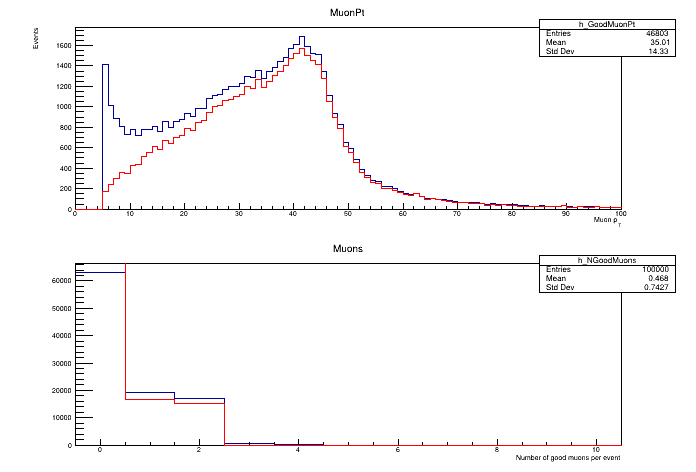

In [4]:
# SOLUTION
c = ROOT.TCanvas()
c.Divide(1,2)
c.cd(1)
h_MuonPt.Draw()
h_GoodMuonPt.Draw("sames")
c.cd(2)
h_NMuons.Draw()
h_NGoodMuons.Draw("sames")
h_GoodMuonPt.SetLineColor(ROOT.kRed)
h_GoodMuonPt.SetXTitle("Muon P_{T} [GeV]")
h_NGoodMuons.SetLineColor(ROOT.kRed)
h_NGoodMuons.SetXTitle("Número de muones por suceso")
c.Draw()
c.SaveAs("example_plot.png")

**4) Analyse what you have obtained**

- How are the muons per event?
- How would you characterise them in terms of pt, eta, phi...?
- How many muons are tipically per event? Why?
- What is the effect of the id and isolation cuts?

$\color{red}{\text{You can repeat the same exercise for electrons and see how the results look like.}}$

**5) Save the histograms in a root file so we can work with them later.**

In [5]:
# Solution
out = ROOT.TFile('histosMuonQuality_%s.root' % dy_sample, "RECREATE")
out.cd()
h_MuonPt.Write()
h_GoodMuonPt.Write()
h_NMuons.Write()
h_NGoodMuons.Write()

f.Close()
out.Close()


## Part 2: Invariant mass

$\color{red}{\text{Goals of this exercise:}}$
- Select the two most energetic muons per event
- Reconstruct the Z bosons and their invariant mass
    


**1) Load the input file**
In this case, let's work with $H \rightarrow ZZ \rightarrow 4l$ events, stored in `SMHiggsToZZTo4L.root`

In [6]:
# Solution
import math
higgs_label = "SMHiggsToZZTo4L"
f = ROOT.TFile.Open(higgs_label + ".root")
tree = f.Get("demo/ExampleTree")
entries=tree.GetEntries()
print("Tree has %d events" % entries)


Tree has 100000 events


**2) Before looking at the tree, let's draw the dimuon mass histogram already stored in the file**

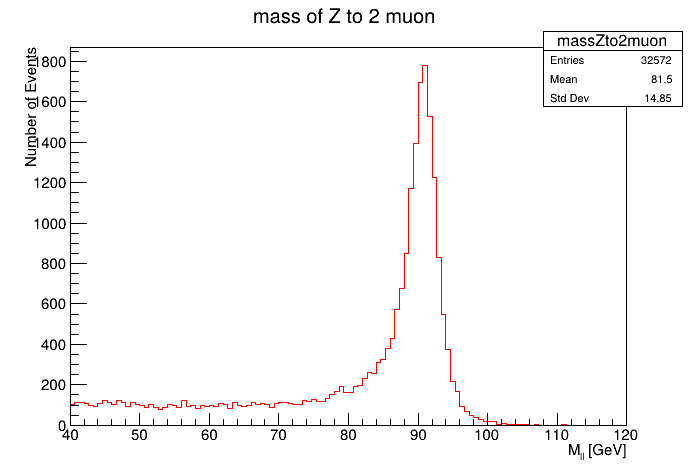

In [7]:
# SOLUTION
# dimuon mass histogram is named 'massZto2muon', stored in the 'demo' directory.
histoReference = f.Get("demo/massZto2muon")
c = ROOT.TCanvas()
histoReference.SetLineColor(ROOT.kRed)
histoReference.SetXTitle("M_{ll} [GeV]")
histoReference.Draw()
c.Draw()

**3) Let's work now with the tree in order to compute the Z invariant mass.**

We can consider three possible methods.

**First method: compute the invariant mass from the energy and momentum of the particle**

The invariant mass of a particle can be obtained as

$M = \sqrt{E²-|p|²}$

where $E$ and $|p|$ and the energy and momentum of the particle.

In the $Z\rightarrow \mu\mu$ case, the $Z$ energy and momentum can be obtained as

$E = E_{\mu_1} + E_{\mu_2}$, $|p| = \sqrt{p_{x}²+p_{y}²+p_{z}²}$ 

where $p_i$ can be obtained as the sum of the $p_{i}$ of the two particles. For example:

$p_{x} = p_{x_{\mu_1}} + p_{x_{\mu_2}}$ 

In our tree, the momentum of the particles is stored in cylindrical coordinates ($p_T$, $\eta$, $\phi$). In order to convert to $p_x$, $p_y$, and $p_z$, we can consider:
- $p_{x} = p_{T} · \cos(\phi)$    
- $p_{y} = p_{T} · \sin(\phi)$ 
- $p_{z} = p_{T} · \sinh(\eta)$ 

Now let's compute the invariant mass from the Z particle assuming it has decayed into the two most energetic muons in the event.

In [8]:
# Solution
# Define the histogram of the invariant mass with 40 bins, between 40 and 120 GeV.
h_InvariantMassDiMuon = ROOT.TH1F("h_InvariantMassDiMuon", "Invariant Mass from the 2 muons; M [GeV]; Events", 40, 40, 120)
muon_mass=0.105 # mass in GeV
for event in tree: # loop sobre los sucesos del tree 
    if event.nGoodMuons<2:
        continue

    # Let's select the two most energetic (largest pt) good muons
    # Define two variables that will store the pt of the two most energetic good muons and their indexes inside the muon array
    muon_1_pt = 0
    muon_2_pt = 0
    muonindex_1 = -1
    muonindex_2 = -1

    for i in range(0, event.nMuons):
        if event.idMuons[i] != 1:
            continue
        if event.isoMuons[i] >= 0.4:
            continue

        if event.ptMuons[i] > muon_1_pt:
           muonindex_2 = muonindex_1 
           muon_2_pt = muon_1_pt
           muonindex_1 = i 
           muon_1_pt = event.ptMuons[i]
        elif event.ptMuons[i] > muon_2_pt:
           muonindex_2 = i
           muon_2_pt = event.ptMuons[i]

    # Now that we have stored the indexes of the most energetic muons under muonindex_1 and muonindex_2, we can use them to extract
    # their values of pt, eta, phi, and charge

    muon_1_eta=event.etaMuons[muonindex_1]
    muon_1_phi=event.phiMuons[muonindex_1]
    muon_1_charge=event.chargeMuons[muonindex_1]

    muon_2_eta=event.etaMuons[muonindex_2]
    muon_2_phi=event.phiMuons[muonindex_2]
    muon_2_charge=event.chargeMuons[muonindex_2]

    # Given that Z is a neutral particle, both muons need to have opposite charge.
    if muon_1_charge * muon_2_charge != -1:
    # one could also use muon_1_charge + muon_2_charge != 0, assuming that the object is stored as a muon only its |charge\ == 1
        continue

    # Convert into cartesian coordinates and extract the energy and momentum of each muon
    muon_1_px = muon_1_pt * math.cos(muon_1_phi)
    muon_1_py = muon_1_pt * math.sin(muon_1_phi)
    muon_1_pz = muon_1_pt * math.sinh(muon_1_eta)

    muon_2_px = muon_2_pt * math.cos(muon_2_phi)
    muon_2_py = muon_2_pt * math.sin(muon_2_phi)
    muon_2_pz = muon_2_pt * math.sinh(muon_2_eta)

    muon_1_p = math.sqrt(muon_1_px * muon_1_px + muon_1_py * muon_1_py + muon_1_pz * muon_1_pz)
    muon_2_p = math.sqrt(muon_2_px * muon_2_px + muon_2_py * muon_2_py + muon_2_pz * muon_2_pz)

    muon_1_e = math.sqrt(muon_1_p * muon_1_p + muon_mass * muon_mass)
    muon_2_e = math.sqrt(muon_2_p * muon_2_p + muon_mass * muon_mass)
    
    # Obtain the momentum and energy of the Z->mumu candidate
    Z_px = (muon_1_px + muon_2_px)
    Z_py = (muon_1_py + muon_2_py)
    Z_pz = (muon_1_pz + muon_2_pz)
    Z_e = muon_1_e + muon_2_e
    Z_p = math.sqrt(Z_px * Z_px + Z_py * Z_py + Z_pz * Z_pz)

    # Finally, obtain the mass and fill the h_InvariantMassDiMuon histogram
    Z_mass = math.sqrt(Z_e*Z_e - Z_p*Z_p)
    h_InvariantMassDiMuon.Fill(Z_mass)

**Draw the histogram you obtained**

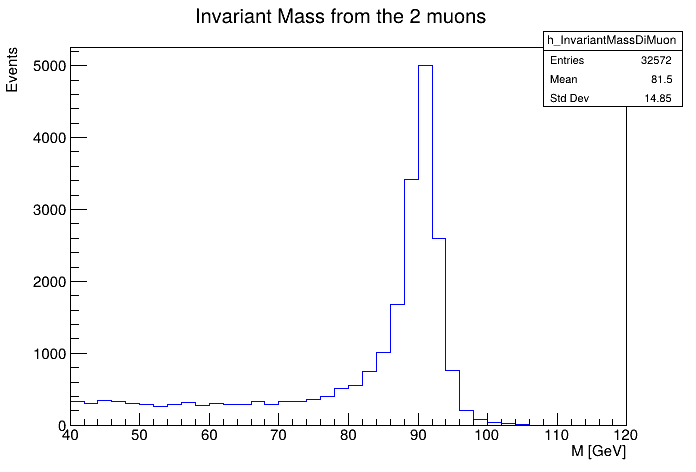

In [9]:
c2 = ROOT.TCanvas()

# Define the colour 
h_InvariantMassDiMuon.SetLineColor(ROOT.kBlue)

# Draw the histogram and canvas
h_InvariantMassDiMuon.Draw()
c2.Draw()

**Second method: compute the invariant mass directly from cylindrical coordinates**

Assuming that the muon mass is much smaller than the $Z$ mass, we can set it to 0 and compute the invariant mass of the dilepton system as


$M_{\ell\ell}= \sqrt{ 2 · p_{T_{muon1}} · p_{T_{muon2}} · (\cosh{(\eta_{muon1}-\eta_{muon2})}-\cos{(\phi_{muon1} - \phi_{muon2})})}$

Compute the invariant mass of the two most energetic muons with this method and compare the resulting histogram with the one obtained using the previous method.

In [11]:
h_InvariantMassDiMuon_v2 = ROOT.TH1F("h_InvariantMassDiMuon_v2", "Invariant Mass 2 Muons; M [GeV]; Events", 40, 40, 120)
muon_mass=0.105  #GeV
for event in tree: # loop sobre los sucesos del tree 
    if event.nGoodMuons<2:
            continue

    # Let's extract the two most energetic good muons in a more compact way 

    listGoodMuons = []
    for i in range(0, event.nMuons):
        if event.idMuons[i] != 1:
            continue
        if event.isoMuons[i] >= 0.4:
            continue

        listGoodMuons.append([i, event.ptMuons[i]])

    ordered_list = sorted(listGoodMuons, key=lambda elem: elem[1] ,reverse=True)
    if len(listGoodMuons) < 2:
        continue

    # Extract the pt, eta, phi, and charge from the two most energetic muons
    muonindex_1 = ordered_list[0][0]
    muonindex_2 = ordered_list[1][0]

    muon_1_pt = event.ptMuons[muonindex_1]
    muon_1_eta = event.etaMuons[muonindex_1]
    muon_1_phi = event.phiMuons[muonindex_1]
    muon_1_charge = event.chargeMuons[muonindex_1]

    muon_2_eta = event.etaMuons[muonindex_2]
    muon_2_phi = event.phiMuons[muonindex_2]
    muon_2_pt = event.ptMuons[muonindex_2]
    muon_2_charge = event.chargeMuons[muonindex_2]

    # Check that both muons have opposite charges
    if muon_1_charge * muon_2_charge != -1:
        continue

    # Compute the Z mass using the second method

    Z_mass_v2 = math.sqrt(2*muon_1_pt*muon_2_pt*(math.cosh(muon_1_eta-muon_2_eta)-math.cos(muon_1_phi - muon_2_phi)))

    h_InvariantMassDiMuon_v2.Fill(Z_mass_v2)


Warning in <TFile::Append>: Replacing existing TH1: h_InvariantMassDiMuon_v2 (Potential memory leak).


**Draw the histogram**

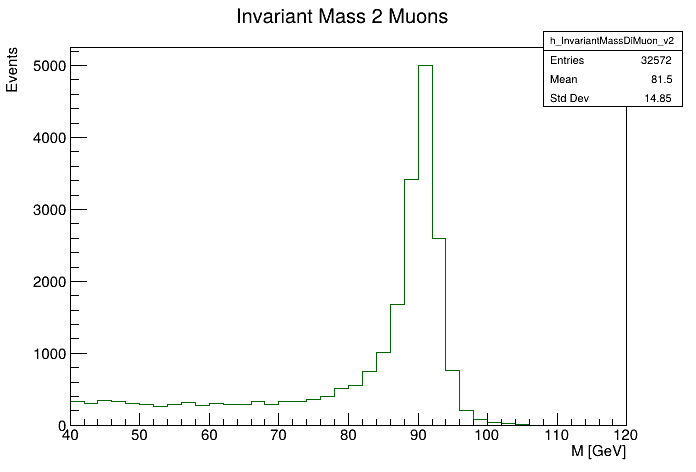

In [12]:
c3 = ROOT.TCanvas()
h_InvariantMassDiMuon_v2.SetLineColor(ROOT.kGreen+3)
h_InvariantMassDiMuon_v2.Draw()
c3.Draw()

**Third method: Using TLorentzVectors**
ROOT has a very useful class, TLorentzVector, that can store the 4-vector of a particle. TLorentzVectors can be combined to build new particles, and their mass can be extracted using the `M()` method.

In [13]:
# SOLUTION
h_InvariantMassDiMuon_v3 = ROOT.TH1F("h_InvariantMassDiMuon_v3","Invariant Mass 2 Muons; M [GeV]", 40, 40, 120)
muon_mass=0.105 #GeV
for event in tree: # loop over the events in the tree
    if event.nGoodMuons<2:
        continue

    listGoodMuons=[]

    for i in range(0, event.nMuons):
        if event.idMuons[i]!=1:
            continue
        if event.isoMuons[i]>=0.4:
            continue

        listGoodMuons.append( [i, event.ptMuons[i]])

    ordered_list = sorted (listGoodMuons, key=lambda pt: pt[1], reverse=True)

    if len(listGoodMuons) < 2:
        continue

    muonindex_1 = ordered_list[0][0]
    muonindex_2 = ordered_list[1][0]

    muon_1_pt = event.ptMuons[muonindex_1]
    muon_1_eta = event.etaMuons[muonindex_1]
    muon_1_phi = event.phiMuons[muonindex_1]
    muon_1_charge = event.chargeMuons[muonindex_1]

    muon_2_eta = event.etaMuons[muonindex_2]
    muon_2_phi = event.phiMuons[muonindex_2]
    muon_2_pt = event.ptMuons[muonindex_2]
    muon_2_charge = event.chargeMuons[muonindex_2]
    
    # Check that both muons have opposite charge
    if muon_1_charge * muon_2_charge != -1:
        continue

    # Build LorentzVectors using the SetPtEtaPhiM method

    muonLV_1 = ROOT.TLorentzVector()
    muonLV_1.SetPtEtaPhiM(muon_1_pt, muon_1_eta, muon_1_phi, muon_mass)
    muonLV_2 = ROOT.TLorentzVector()
    muonLV_2.SetPtEtaPhiM(muon_2_pt, muon_2_eta, muon_2_phi, muon_mass)

    ZLV = ROOT.TLorentzVector()
    ZLV = muonLV_1 + muonLV_2

    Z_mass_v3 = ZLV.M()

    h_InvariantMassDiMuon_v3.Fill(Z_mass_v3)

Let's now draw the histogram

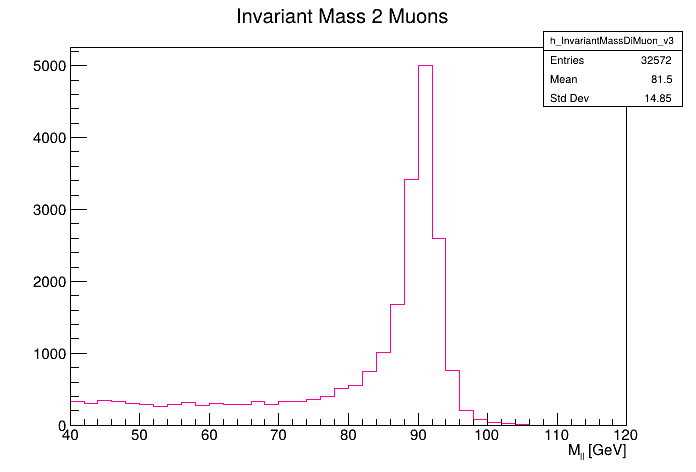

In [15]:
# SOLUTION
c4 = ROOT.TCanvas()
h_InvariantMassDiMuon_v3.SetLineColor(ROOT.kPink + 10)
h_InvariantMassDiMuon_v3.Draw("hist")
c4.Draw()

**4) Some questions you may want to ask yourself**

- If the Z mass is around 91 GeV, why do we see a broader peak?
- Why do we obtain a ~constant tail below 80 GeV?
- What happens if I use a different sample? e.g. DYJetsToLL_M-50, the one from the first exercise.
- And for a data sample? Input file is called `DoubleMuParkedRun2012BC.root`. Be careful! This file has a huge number of events, so it'll probably take very long to run.

In [ ]:
# END PART 2

## Part 3: Normalising

Before starting with the Higgs reconstruction we need to learn how to **normalise** histograms, so the the ones obtained from Monte Carlo simulations can be compared to the actual data from the detector. To do so we need to define two quantities

- **Cross section** ($\sigma$), defined as the probability that a given process is given after the collision of the particles. It has units of area (m${}^2$), but in Particle Physics we use the **barn** (1b $ = 10^{-28}$ m${}^2$) and its multiples (mb, pb, fb, ...)
- **Luminosity**: related to the number of events and the cross section as
  $L = \frac{1}{\sigma}\cdot \frac{dN}{dt}$. Intregrating the luminosity in a period of time we obtaine the **integrated luminosity**, measured in inversed units of the cross section (pb${}^{-1}$, fb${}^{-1}$, ...). The larger the integrated luminosity, the more data events we will have and the probability that we could have collected enough events of a particular process so it can be statistically observed.

**How do we obtain the values of the cross sections of the different processes?**

Cross sections are computed using appropriated tools, such as [MCFM](https://mcfm.fnal.gov/) or [FEWZ](http://dx.doi.org/10.1103/PhysRevD.86.094034). Their values are estimated considering proton-proton collisions with a center-of-mass energy of 8 TeV.

- $Z\rightarrow\ell^{+}\ell^{-}$, with $m_{ll}>50 GeV$: 1177.3 pb.
- $pp\rightarrow ZZ -> 4\mu$: 7.7 pb.
- $gg\to H\to ZZ \to 4\mu$: 0.0065 pb.


**Let's work!**
Let's compare the event yields after normalization for data (`DoubleMuParkedRun2012BC.root`), signal (`SMHiggsToZZTo4L`), and backgrounds (`DYJetsToLL_M-50` and `ZZTo4mu`) around the Z peak.

**1) Open the different input files for signal, data, and backgrounds**

In [28]:
# SOLUTION
import ROOT
import math

# Signal -> SMHiggsToZZTo4L.root
label_signal = "SMHiggsToZZTo4L"
f_signal = ROOT.TFile.Open(label_signal + ".root")
tree_signal = f_signal.Get("demo/ExampleTree")

# Data -> DoubleMuParkedRun2012BC.root
label_data = "DoubleMuParkedRun2012BC"
f_data = ROOT.TFile.Open(label_data + ".root")
tree_data = f_data.Get("demo/ExampleTree")

# Background -> DYJetsToLL_M-50.root and ZZTo4mu.root
f_MC = {}

label_MC = ["DYJetsToLL_M-50", "ZZTo4mu"]
for label in label_MC:
    f_MC[label] = ROOT.TFile.Open(label + ".root")
tree_dic = {}
for file in f_MC:
    tree_dic[file] = f_MC[file].Get("demo/ExampleTree")
 
# print number of events per file
entries_signal = tree_signal.GetEntries()
print("Signal tree has", entries_signal, "events")
entries_data = tree_data.GetEntries()
print("Data tree has", entries_data, "events")
for file in tree_dic:
    print("Background tree", file, "has", tree_dic[file].GetEntries(), "entries")

Signal tree has 100000 events
Data tree has 60935977 events
Background tree DYJetsToLL_M-50 has 100000 entries
Background tree ZZTo4mu has 1499064 entries


**2) To avoid looping over all events again, let's directly extract the histograms from the input files**

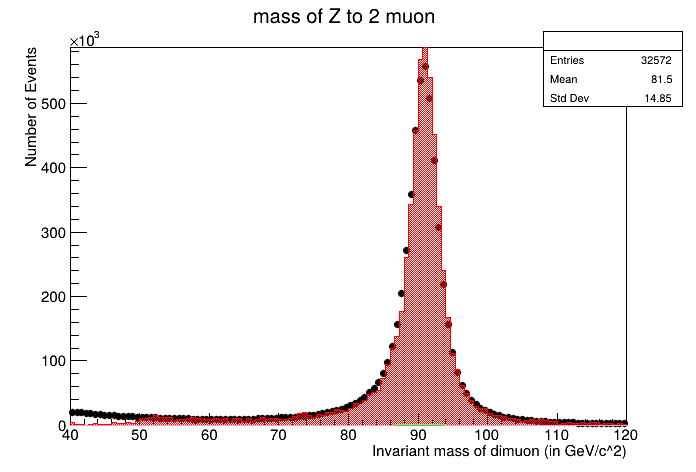

In [32]:
# Solution
# gStyle.SetOptStat(0) # Cosmetics, removes the stats box on the top right

# Inside the 'demo' directory, get the massZto2muon' histogram
# Remember, we must not normalise the data histogram
histoData = f_data.Get("demo/massZto2muon")
canvas = ROOT.TCanvas()
histoData.Draw("E")
histoData.SetMarkerStyle(20)
histoData.SetMarkerSize(0.8)
canvas.Draw()

integrated_luminsitoy = 11580 #pb
hzzXsec = 0.0065 # xs gg-> H -> ZZ -> 4mu [pb]
zzXsec = 0.077 * 1.386  # xs gg -> ZZ -> 4mu [pb]
dyM50Xsec = 1177.3 * 3 # xs gg -> Z -> mumu [pb]

xs = {"DYJetsToLL_M-50": dyM50Xsec, "ZZTo4mu": zzXsec}
iter = 0

bkg_histo = None

for file in tree_dic:
    histo = f_MC[file].Get("demo/massZto2muon")
    histo.SetLineColor(iter+2)
    histo.SetFillColor(iter+2)
    histo.SetFillStyle(3001)
    histo.GetYaxis().SetRangeUser(0, 1000000)
    histo.Scale(xs[file]*integrated_luminosity/tree_dic[file].GetEntries())
    histo.Draw("sames hist")
    if (iter == 0): bkg_histo = histo.Clone()
    else: bkg_histo.Add(histo)
    histo.Clear()
    iter = iter+1
    
# Let's draw the signal on top of the other histograms
histoSignal = f_signal.Get("demo/massZto2muon")
histoSignal.Draw("hist sames")
histoSignal.GetYaxis().SetRangeUser(0, 1000000)
histo.Scale(hzzXsec * integrated_luminosity / entries_signal)
histoSignal.Clear()
histoSignal.SetLineColor(ROOT.kPink + 1)

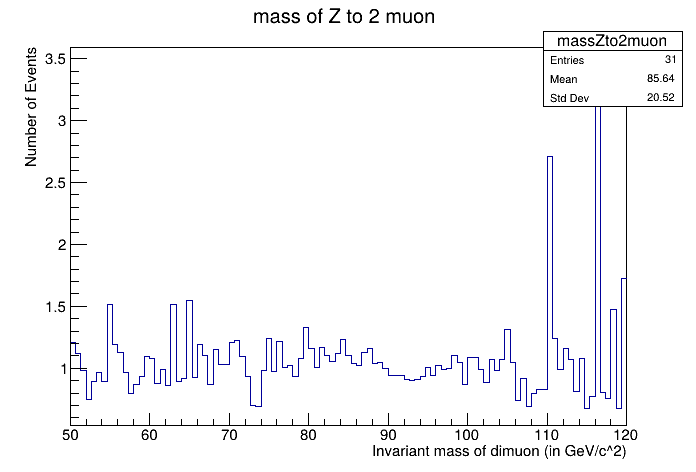

In [34]:
# Ratio DATA / MC
hRatio = histoData.Clone()
hRatio.Divide(bkg_histo)
hRatio.GetXaxis().SetRangeUser(50,120)
canvasRatio = ROOT.TCanvas()
hRatio.Draw("hist")
canvasRatio.Draw()

# Now we can look for the Higgs boson!

We have already all the tools needed to reproduce the plot used in the search for $H\to ZZ \to 4l$. We will simplify it a bit by only looking at the $2\mu2e$ channel and only part of the 2012 data. A more detailed version of this analysis is located in https://github.com/cms-opendata-analyses/HiggsExample20112012, where you can see the final plot:

<div>
<img src="imagenes/mass4l_combine.png" width="800"/>
</div>

In our particular channel, the plot looks like 

<div>
<img src="imagenes/mass2mu2e_small.png" width="800"/>
</div>

$\color{red}{\text{Goals of this exercise}}$
- Select the two most energetic muons and electrons per event
- Reconstruct both Z bosons and the Higgs boson!
- Compare signal, background, and data
    
We will consider three samples:
- Monte Carlo simulation of $pp \to H \to ZZ \to 4l$: file `SMHiggsToZZTo4l.root`
- Monte Carlo simulation of $pp \to ZZ \to 2\mu2e$: file `ZZTo2mu2e.root`
- 2012 data: file `DoubleMuParkedRun2012BC.root`


### Some constants that will be needed for this exercise

In [37]:
muon_mass = 0.105658
electron_mass = 0.0005109989
Z_mass = 91.1876

# Luminosity
Lumi = 11580 # pb-1

# Cross-sections :
hzzXsec = 0.0065 # pb. gg -> H -> ZZ -> 4l
zzXsec = 0.18 * 1.386  #pb. gg -> ZZ -> 4l

### 1) Load the input files

In [38]:
import ROOT
import math

labelHZZ = "SMHiggsToZZTo4L" 
labelZZ = "ZZTo2mu2e"
labelDatos = "DoubleMuParkedRun2012BC"

path = "./"

fHZZ = ROOT.TFile(path + labelHZZ + ".root")
fZZ = ROOT.TFile(path + labelZZ + ".root")
fData = ROOT.TFile(path + labelDatos + ".root")

treeHZZ = fHZZ.Get("demo/ExampleTree")
treeZZ = fZZ.Get("demo/ExampleTree")
treeData = fData.Get("demo/ExampleTree")
                       
entriesHZZ=treeHZZ.GetEntries()
entriesZZ=treeZZ.GetEntries()
entriesData=treeData.GetEntries()

print("HZZ and ZZ trees have %s and %s events respectively" % (entriesHZZ, entriesZZ))
print("Data tree has %s events" % entriesData)

HZZ and ZZ trees have 100000 and 100000 events respectively
Data tree has 60935977 events


### 2) Look for the two muons and two electrons

Let's work with ```ROOT.TLorentzVector``` as in the previous exercise. We'll build the TLorentzVector for each muon and electron, sum them to obtain the 4-vectors of each $Z$ and sum them again to reconstruct the Higgs boson. 

Let's start by not applying any additional selection, just reconstruct both $Z$ from the two most energetic electrons and muons. These electrons and muons must be *good*, i.e. satisfy the requirements on ID and isolation already considered in the previous exercises.



In [43]:
def get_mass_nosel(sample_name, input_tree):
    h_MassHiggs4L_NoSel = ROOT.TH1F("h_MassHiggs4L_NoSel_%s" % sample_name, "Higgs mass; M [GeV]", 37, 70, 181)
    
    SelectedEvents = 0
    TotalEvents = input_tree.GetEntries()

    for event in input_tree: # loop over the events in the input tree
        if event.nGoodMuons < 2 or event.nGoodElectrons < 2:
                continue

        # Look for the two most energetic muons

        listGoodMuons=[]

        for i in range(event.nMuons):
                if event.idMuons[i]!=1:
                        continue
                if event.isoMuons[i]>=0.4:
                        continue
                listGoodMuons.append( [i, event.ptMuons[i]] )

        order = sorted (listGoodMuons, key=lambda elem: elem[1], reverse=True)

        if len(listGoodMuons) < 2:
                continue

        muon_1 = ROOT.TLorentzVector()
        muon_index_1=order[0][0]
        muon_1_charge = event.chargeMuons[muon_index_1]
        muon_1.SetPtEtaPhiM(event.ptMuons[muon_index_1], event.etaMuons[muon_index_1], event.phiMuons[muon_index_1], muon_mass)

        muon_2 = ROOT.TLorentzVector()
        muon_index_2=order[1][0]
        muon_2_charge = event.chargeMuons[muon_index_2]
        muon_2.SetPtEtaPhiM(event.ptMuons[muon_index_2], event.etaMuons[muon_index_2], event.phiMuons[muon_index_2], muon_mass)

        # look for the two most energetic electrons
        listGoodElectrons=[]
        for i in range(event.nElectrons):
                if event.idElectrons[i] != 1:
                        continue
                if event.isoElectrons[i] >= 0.4:
                        continue
                listGoodElectrons.append([i, event.ptElectrons[i]])

        order = sorted(listGoodElectrons, key=lambda pt: pt[1], reverse=True)

        if len(listGoodElectrons) < 2:
                continue

        electron_1 = ROOT.TLorentzVector()
        electron_index_1 = order[0][0]
        electron_1_charge = event.chargeElectrons[electron_index_1]
        electron_1.SetPtEtaPhiM(event.ptElectrons[electron_index_1], event.etaElectrons[electron_index_1], event.phiElectrons[electron_index_1], electron_mass)

        electron_2 = ROOT.TLorentzVector()
        electron_index_2 = order[1][0]
        electron_2_charge = event.chargeElectrons[electron_index_2]
        electron_2.SetPtEtaPhiM(event.ptElectrons[electron_index_2], event.etaElectrons[electron_index_2], event.phiElectrons[electron_index_2], electron_mass)
        
        # Check both electrons and muons have opposite charge

        if (muon_1_charge + muon_2_charge) != 0 :
                continue

        if (electron_1_charge + electron_2_charge) != 0 :
                continue

        # Reconstruct the Zs and the H

        Zmumu = muon_1 + muon_2
        Zee = electron_1 + electron_2


        HCand = Zmumu + Zee

        h_MassHiggs4L_NoSel.Fill(HCand.M())
        SelectedEvents += 1

    print("Selected events from the total analysed: %s / %s " % (SelectedEvents, TotalEvents))
    return h_MassHiggs4L_NoSel
    
h_MassHiggs4L_NoSel_HZZ = get_mass_nosel("HZZ", treeHZZ)

Selected events from the total analysed: 5573 / 100000 


Warning in <TFile::Append>: Replacing existing TH1: h_MassHiggs4L_NoSel_HZZ (Potential memory leak).


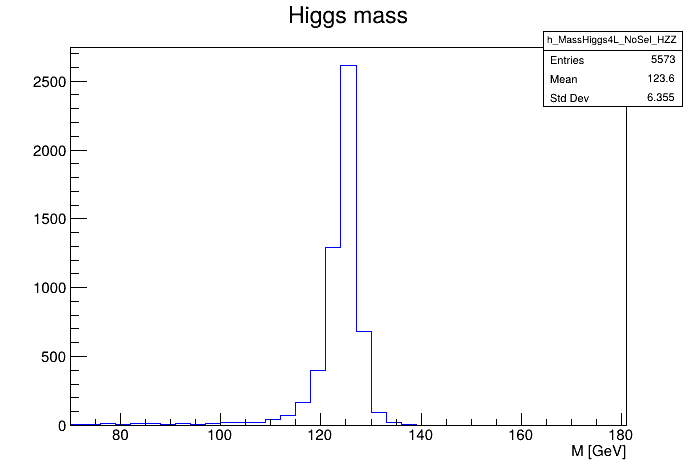

In [44]:
# Draw the histogram
c2 = ROOT.TCanvas()
h_MassHiggs4L_NoSel_HZZ.SetLineColor(ROOT.kBlue)
h_MassHiggs4L_NoSel_HZZ.Draw()
c2.Draw()


### 3) Is that all?

No! We can try to improve the signal sensitivity by applying a selection based on the Higgs topology. 

Given that $m_H < 2 \cdot m_Z$, we need to look for events where one of the $Z$ bosons is produced on-shell and the other off-shell, i.e. outside the resonance. Then, we will require that the $Z$ boson with a mass closer to the nominal $Z$ mass has a mass within 40 and 120 GeV, and the off-shell $Z$ between 12 and 120 GeV. On top of that, we will require that the leptons coming from the on-shell $Z$ have $p_T$ of at least 20 and 10 GeV.

In [46]:
def get_mass_withsel(sample_name, input_tree):
    h_MassZ1 = ROOT.TH1F("h_MassZ1_%s" % sample_name, "Mass Z1", 24, 0., 120.)
    h_MassZ2 = ROOT.TH1F("h_MassZ2_%s" % sample_name, "Mass Z2", 24, 0., 120.)
    h_MassHiggs4L = ROOT.TH1F("h_MassHiggs4L_%s" % sample_name, "Mass Higgs", 37, 70., 181.)
    
    SelectedEvents = 0
    TotalEvents = input_tree.GetEntries()
    
    for event in input_tree: # loop over the events in the input tree
        if event.nGoodMuons<2 or event.nGoodElectrons<2:
                continue

        # look for the two most energetic muons
        listGoodMuons=[]

        for i in range(event.nMuons):
                if event.idMuons[i]!=1:
                        continue
                if event.isoMuons[i]>=0.4:
                        continue
                listGoodMuons.append( [i, event.ptMuons[i]] )
        order = sorted (listGoodMuons, key=lambda pt: pt[1], reverse=True)

        if len(listGoodMuons) < 2:
                continue

        muon_1 = ROOT.TLorentzVector()
        muon_index_1=order[0][0]
        muon_1_charge = event.chargeMuons[muon_index_1]
        muon_1.SetPtEtaPhiM(event.ptMuons[muon_index_1], event.etaMuons[muon_index_1], event.phiMuons[muon_index_1], muon_mass)

        muon_2 = ROOT.TLorentzVector()
        muon_index_2=order[1][0]
        muon_2_charge = event.chargeMuons[muon_index_2]
        muon_2.SetPtEtaPhiM(event.ptMuons[muon_index_2], event.etaMuons[muon_index_2], event.phiMuons[muon_index_2], muon_mass)

        # look for the most energetic electrons
        listGoodElectrons=[]
        for i in range(event.nElectrons):
                if event.idElectrons[i] != 1:
                        continue
                if event.isoElectrons[i] >= 0.4:
                        continue
                listGoodElectrons.append([i, event.ptElectrons[i]])

        order = sorted(listGoodElectrons, key=lambda pt: pt[1], reverse=True)

        if len(listGoodElectrons) < 2:
            continue

        electron_1 = ROOT.TLorentzVector()
        electron_index_1 = order[0][0]
        electron_1_charge = event.chargeElectrons[electron_index_1]
        electron_1.SetPtEtaPhiM(event.ptElectrons[electron_index_1], event.etaElectrons[electron_index_1], event.phiElectrons[electron_index_1], electron_mass)

        electron_2 = ROOT.TLorentzVector()
        electron_index_2 = order[1][0]
        electron_2_charge = event.chargeElectrons[electron_index_2]
        electron_2.SetPtEtaPhiM(event.ptElectrons[electron_index_2], event.etaElectrons[electron_index_2], event.phiElectrons[electron_index_2], electron_mass)

        # Check that the two electrons and muons have opposite charge
        if (muon_1_charge + muon_2_charge) != 0 :
            continue

        if (electron_1_charge + electron_2_charge) != 0 :
            continue

        # Reconstruct the two Zs and the Higgs boson
        Zmumu = muon_1 + muon_2
        Zee = electron_1 + electron_2

        HCand = Zmumu + Zee
        
        Z1 = ROOT.TLorentzVector()
        Z2 = ROOT.TLorentzVector()

        # Apply the on-shell and off-shell Z selection
        selectEvent = False

        # Which Z is the on-shell and which one is the off-shell?

        if abs(Zmumu.M() - Z_mass) < abs(Zee.M() - Z_mass):  # Z1 = Zmumu
            # Require that the two muons have pts > 20 and > 10 GeV
            if muon_1.Pt() > 20 and muon_2.Pt() > 10: # Require that the two muons have pts > 20 and > 10 GeV
                if Zmumu.M() > 40 and Zmumu.M() < 120 and Zee.M() > 12 and Zee.M() < 120: # Selection on the on-shell (Zmumu) and off-shell (Zee) Zs
                    Z1 = Zmumu
                    Z2 = Zee
                    selectEvent = True

        else:  # Z1 = Zee
            # Require that the two electrons have pts > 20 and > 10 GeV
            if electron_1.Pt() > 20 and electron_2.Pt() > 10 :
                if Zee.M() > 40 and Zee.M() < 120 and Zmumu.M() > 12 and Zmumu.M() < 120: # Selection on the on-shell (Zee) and off-shell (Zmumu) Zs
                    Z1 = Zmumu
                    Z2 = Zee
                    selectEvent = True

        if selectEvent==True:
            h_MassHiggs4L.Fill(HCand.M())
            h_MassZ1.Fill(Z1.M())
            h_MassZ2.Fill(Z2.M())
            SelectedEvents += 1

    print("Selected events out of the total analysed: %s / %s " % (SelectedEvents, TotalEvents))
    return h_MassHiggs4L, h_MassZ1, h_MassZ1


h_MassHiggs4L_HZZ, h_MassZ1_HZZ, h_MassZ2_HZZ  = get_mass_withsel("HZZ", treeHZZ)

Selected events out of the total analysed: 4932 / 100000 


Warning in <TFile::Append>: Replacing existing TH1: h_MassZ1_HZZ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_MassHiggs4L_HZZ (Potential memory leak).


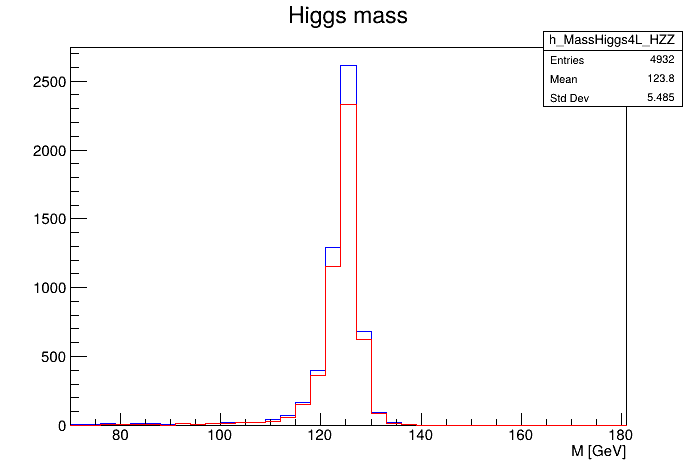

In [49]:
# Draw the histograms before and after the selection
c2 = ROOT.TCanvas()

h_MassHiggs4L_HZZ.SetLineColor(ROOT.kRed)
h_MassHiggs4L_NoSel_HZZ.Draw()
h_MassHiggs4L_HZZ.Draw("sames")

c2.Draw()

### 4) What has been the effect on the signal?

Didn't affect it much. But what about the background? Produce the same histograms running on the ZZ background sample

In [50]:
h_MassHiggs4L_NoSel_ZZ = get_mass_nosel("ZZ", treeZZ)
h_MassHiggs4L_ZZ, h_MassZ1_ZZ, h_MassZ2_ZZ  = get_mass_withsel("ZZ", treeZZ)

Selected events from the total analysed: 6488 / 100000 
Selected events out of the total analysed: 4128 / 100000 


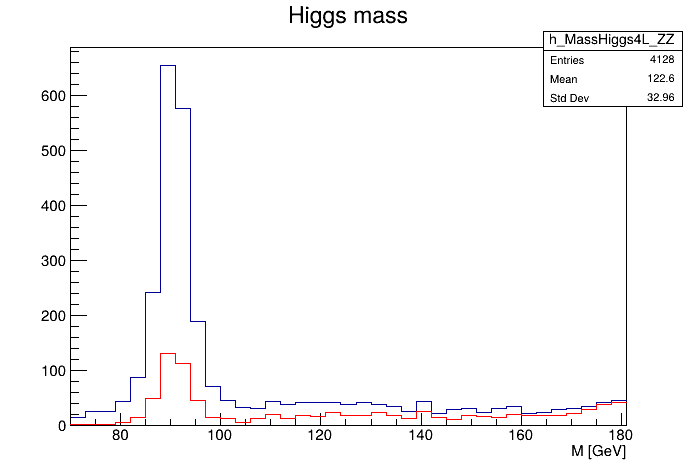

In [52]:
c2 = ROOT.TCanvas()
h_MassHiggs4L_ZZ.SetLineColor(ROOT.kRed)
h_MassHiggs4L_NoSel_ZZ.Draw()
h_MassHiggs4L_ZZ.Draw("sames")
c2.Draw()

### 5) Let's get the final plot!

Normalise each MC process to its cross section and plot them together with the data.

In [53]:
# We would need to produce the same histograms for the data, running
# h_MassHiggs4L_Data, _, _  = get_mass_withsel("Data", treeData)

# However, given that the data file has many events, we had previously run that command and stored it in a root file
histo_file = ROOT.TFile("Exercise_hData.root")
h_MassHiggs4L_Data = histo_file.Get("h_MassHiggs4L_Data").Clone()
#histo_file.Close()

In [54]:
# Normalise the MC histograms considering the luminosity, cross section, and the total number of events
# Be careful to run this only once!
h_MassHiggs4L_HZZ.Scale(hzzXsec * Lumi / entriesHZZ) 
h_MassHiggs4L_ZZ.Scale(zzXsec * Lumi / entriesZZ)

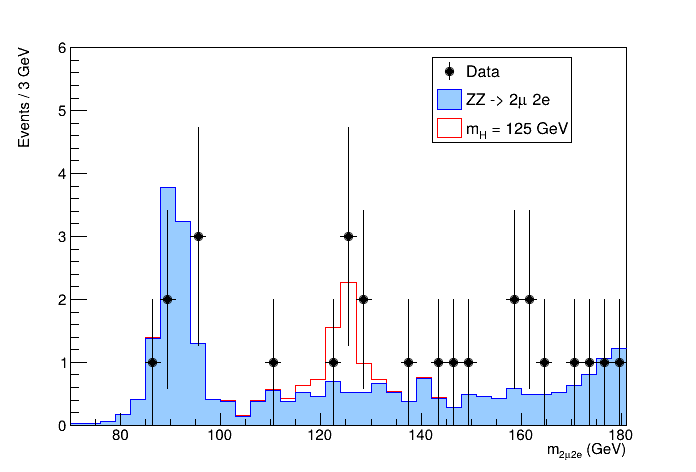

In [58]:
c3 = ROOT.TCanvas()

# Change the colours of the different histograms
h_MassHiggs4L_HZZ.SetLineColor(ROOT.kRed)
h_MassHiggs4L_ZZ.SetLineColor(ROOT.kBlue)
h_MassHiggs4L_ZZ.SetFillColor(ROOT.kAzure-9)
h_MassHiggs4L_Data.SetMarkerStyle(20)
h_MassHiggs4L_Data.SetLineColor(ROOT.kBlack)

# Instead of drawing each histogram independently, we can stack them
mcomb = ROOT.THStack("mcomb", " ") 
mcomb.Add(h_MassHiggs4L_ZZ)
mcomb.Add(h_MassHiggs4L_HZZ)

# Draw them:
mcomb.Draw("hist")
h_MassHiggs4L_Data.Draw("PE,sames")

# Add a legend
leg = ROOT.TLegend(.62, .70, .82, .88)
leg.SetFillColor(0)
leg.AddEntry(h_MassHiggs4L_Data, "Data", "PE")
leg.AddEntry(h_MassHiggs4L_ZZ, "ZZ -> 2#mu 2e", "f")
leg.AddEntry(h_MassHiggs4L_HZZ, "m_{H} = 125 GeV", "f")
leg.Draw()

# Some little cosmetics
mcomb.GetXaxis().SetTitle("m_{2#mu2e} (GeV)");
mcomb.GetYaxis().SetTitle("Events / 3 GeV");
mcomb.GetYaxis().SetTitleOffset(1.2);
mcomb.SetMaximum(6);

ROOT.gStyle.SetOptStat(0) # Remove the stats box on the top right

c3.Draw()

# Congratulations! You have discovered the Higgs boson!
You can now repeat the same exercise in the $H\to ZZ\to4\mu$ channel